# **Importing Data + Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = 'dataset.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(file_path)
df_clean = df

# **Data Cleaning**

In [ ]:
#Remove patient IDs
df_clean = df.iloc[1:, :]
df_clean.columns = df.iloc[0]
#Convert all types of missing values to proper formats
df_clean = df_clean.replace(["-", "—", "N/A", "na", "  ", " ", "", 'null', "NaN"], np.nan)
df_clean['Duration of disease from first symptoms (years)'] = df_clean['Duration of disease from first symptoms (years)'].replace(np.nan, 0)
df_clean['Positive history of Parkinson disease in family'] = df_clean['Positive history of Parkinson disease in family'].replace([np.nan, 'No'], 0)
df_clean['Positive history of Parkinson disease in family'] = df_clean['Positive history of Parkinson disease in family'].replace('Yes', 1)
#Rename columns to be more manageable
df_clean = df_clean.rename(columns={'Age (years)': 'Age',
                                    'Positive history of Parkinson disease in family': 'Family History',
                                    'Age of disease onset (years)': 'Age of disease onset',
                                    'Duration of disease from first symptoms (years)': 'Duration of disease',
                                    'Acceleration of speech timing                                (-/min2)': 'Acceleration of speech timing',
                                    'Gaping                          in-between voiced\nintervals  (-/min)': 'Gaping in-between voiced intervals',
                                    'Decay of unvoiced fricatives              (?/min)': 'Decay of unvoiced fricatives',
                                    'Decay of unvoiced fricatives              (‰/min)': 'Decay of unvoiced fricatives',
                                    'Rate of speech respiration                (-/min)': 'Rate of speech respiration',
                                    'Gaping                         in-between voiced\nintervals                   (-/min)': 'Gaping in-between voiced intervals',
                                    'Rate of speech respiration           (- /min)': 'Rate of speech respiration',
                                    'Rate of speech timing (-/min)': 'Rate of speech timing',
                                    'Entropy of speech timing (-)': 'Entropy of speech timing',
                                    'Duration of pause intervals (ms)': 'Duration of pause intervals',
                                    'Duration of voiced intervals (ms)': 'Duration of voiced intervals',
                                    'Duration of unvoiced stops (ms)': 'Duration of unvoiced stops',
                                    'Relative loudness of respiration (dB)': 'Relative loudness of respiration',
                                    'Pause intervals per respiration (-)': 'Pause intervals per respiration',
                                    'Latency of\nrespiratory exchange (ms)': 'Latency of respiratory exchange',
                                    'Acceleration of speech timing (-/min2)': 'Acceleration of speech timing'
                                    })
df_clean = df_clean.drop(columns=df_clean.columns[12:41])
# Create column for diagnosis (target) - 1 for yes, 0 for no
df_clean['Diagnosed'] = df_clean['Age of disease onset'].fillna(0)
df_clean['Diagnosed'] = df_clean['Diagnosed'].astype(int)
df_clean['Diagnosed'] = df_clean['Diagnosed'].apply(lambda x: 1 if x > 0 else x)
df_clean['Diagnosed_String'] = df_clean['Diagnosed'].map({1: 'Healthy', 0: 'Diagnosed'})
#Separate speech tasks into reading & monologue (in parenthesis)
reading_names = df_clean.iloc[:,12:24].columns
monologue_names = df_clean.iloc[:,24:36].columns
new_reading_names = [name + " (reading)" for name in reading_names]
new_monologue_names = [name + " (monologue)" for name in monologue_names]
df_clean_reading = df_clean.iloc[:,:24]
df_clean_reading = df_clean_reading.rename(columns=dict(zip(reading_names, new_reading_names)))
df_clean_monologue = df_clean.iloc[:,24:]
df_clean_monologue = df_clean_monologue.rename(columns=dict(zip(monologue_names, new_monologue_names)))
df_clean = pd.concat([df_clean_reading, df_clean_monologue], axis=1)
#Convert to numerics
df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')
for col in new_reading_names:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
for col in new_monologue_names:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
#Drop columns that give 100% accuracy
df_clean = df_clean.drop(columns=[np.nan, 'Age of disease onset', 'Duration of disease'])

/tmp/ipython-input-475960034.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Positive history of Parkinson disease in family'] = df_clean['Positive history of Parkinson disease in family'].replace('Yes', 1)


# **EDA Visualization 2**

Created a boxplot grouped by diagnosis for each speech feature

df_clean['Duration of voiced intervals (ms)_1'].max()

In [ ]:
cols = df_clean.iloc[:,12:33].columns.to_list()

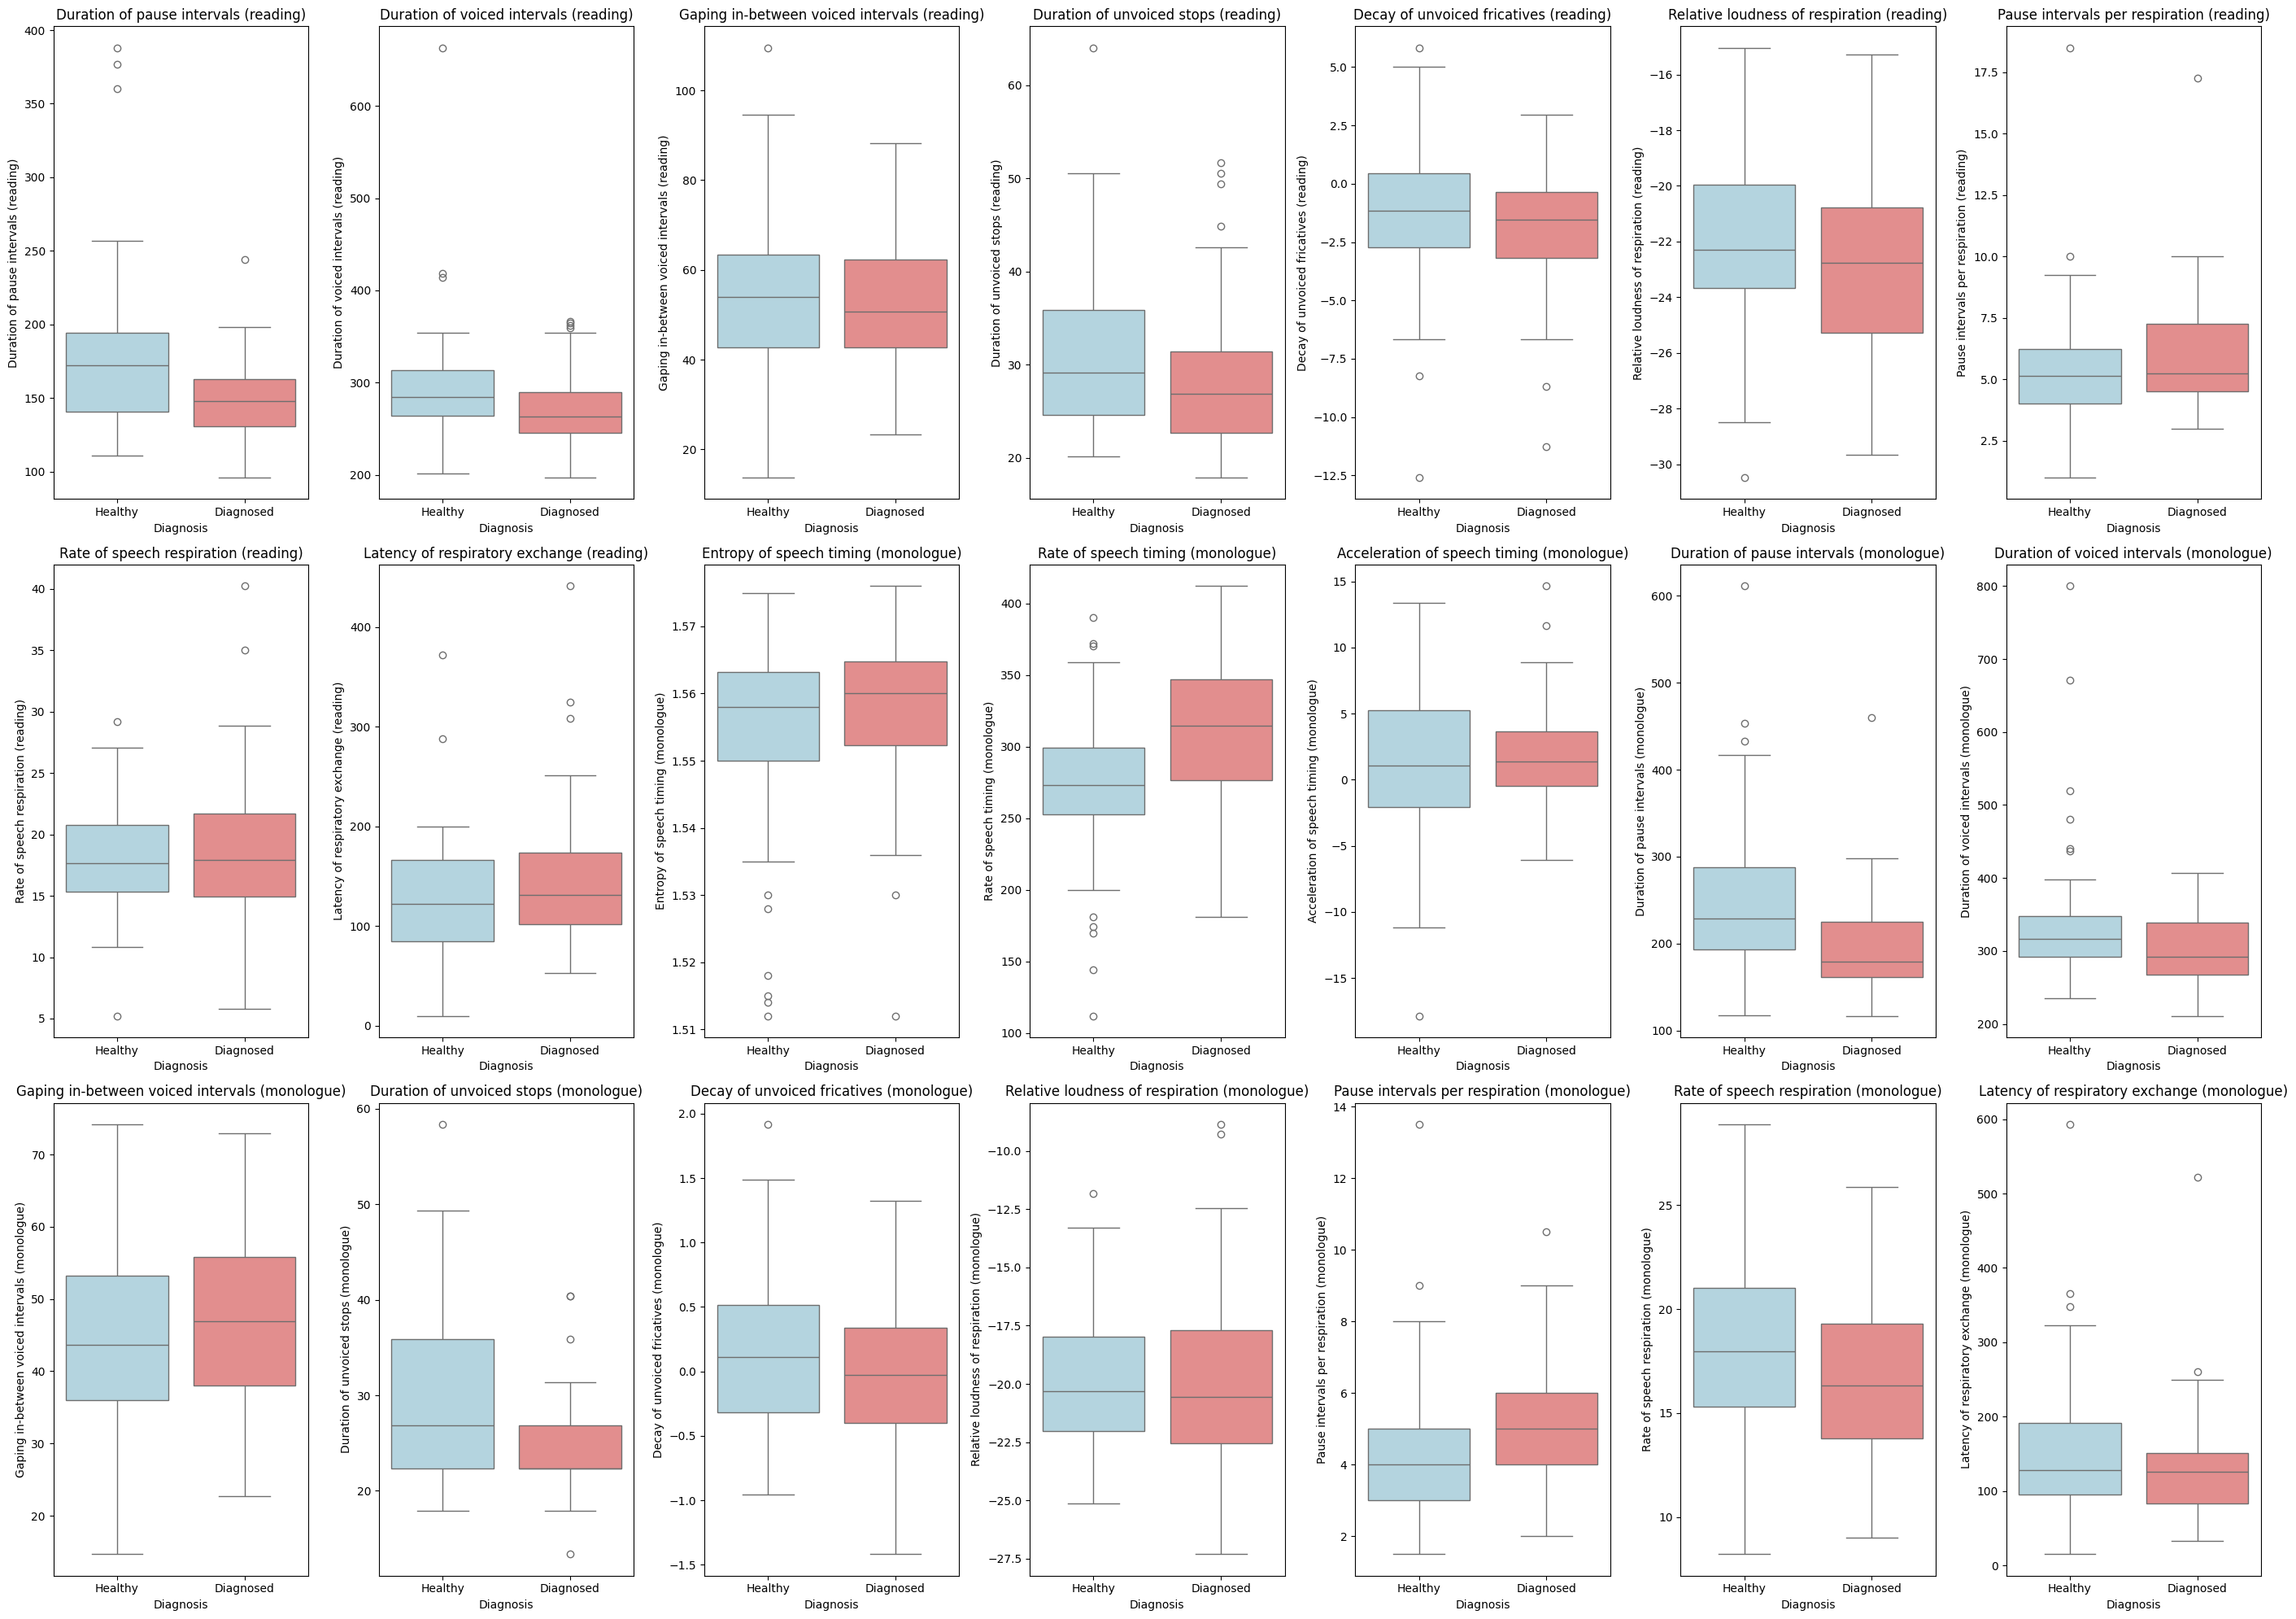

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(4 * 7, 5 * 4))
axes = axes.flatten()

for i, feature in enumerate(cols):
    sns.boxplot(data=df_clean, x = 'Diagnosed_String',  y=feature, hue='Diagnosed_String', palette={"Diagnosed": "lightcoral", "Healthy": "lightblue"}, ax=axes[i])
    axes[i].set_xlabel("Diagnosis")
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

# **Data Preprocessing**

In [ ]:
#Binary map gender and medications to ints
df_clean['Gender'] = df_clean['Gender'].map({'M': 0, 'F': 1}).astype(int)

medication_cols = [
    'Antidepressant therapy',
    'Antiparkinsonian medication',
    'Antipsychotic medication',
    'Benzodiazepine medication'
]

for col in medication_cols:
    df_clean[col] = df_clean[col].map({'No': 0, 'Yes': 1}).fillna(0).astype(int)

,Antidepressant therapy,Antiparkinsonian medication,Antipsychotic medication,Benzodiazepine medication
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0


In [ ]:
#Min-max scaling
from sklearn.preprocessing import MinMaxScaler
df_scaled = df_clean.copy()
numerics = df_clean.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_scaled[numerics] = scaler.fit_transform(df_scaled[numerics])
df_scaled[numerics].head()

,Age,Gender,Family History,Antidepressant therapy,Antiparkinsonian medication,Antipsychotic medication,Benzodiazepine medication,Entropy of speech timing (reading),Rate of speech timing (reading),Acceleration of speech timing (reading),...,Duration of pause intervals (monologue),Duration of voiced intervals (monologue),Gaping in-between voiced intervals (monologue),Duration of unvoiced stops (monologue),Decay of unvoiced fricatives (monologue),Relative loudness of respiration (monologue),Pause intervals per respiration (monologue),Rate of speech respiration (monologue),Latency of respiratory exchange (monologue),Diagnosed
1,0.489796,1.0,0.0,0.0,0.0,0.0,0.0,0.921875,0.675079,0.414037,...,0.082996,0.181664,0.577169,0.200000,0.601560,0.408672,0.375000,0.270924,0.193772,1.0
2,0.693878,1.0,0.0,0.0,0.0,0.0,0.0,0.921875,0.630915,0.751138,...,0.360324,0.089983,0.435104,0.300222,0.177618,0.219512,0.208333,0.656023,0.515571,1.0
3,0.693878,0.0,0.0,0.0,0.0,0.0,0.0,0.812500,0.223975,0.506987,...,0.329960,0.179966,0.576496,0.200000,0.138614,0.759892,0.208333,0.692308,0.321799,1.0
4,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.570312,0.000000,0.279950,...,0.566802,1.000000,0.067418,0.800000,0.662466,0.120867,0.041667,0.298016,0.235294,1.0
5,0.551020,0.0,1.0,0.0,0.0,0.0,0.0,0.757812,0.406940,0.424556,...,0.180162,0.456706,0.317081,0.300000,0.447645,0.270461,0.291667,0.309627,0.235294,1.0


In [ ]:
# Impute remaining NaN values in X with the mean of their respective columns.
df_clean = df_clean.fillna(df_clean.mean(numeric_only=True))
print("NaN values in X filled with column means.")

NaN values in X filled with column means.


In [ ]:
y = df_clean['Diagnosed']
X = df_clean.drop(columns=['Diagnosed', 'Diagnosed_String'])

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


# **Train model: Fitting a KNN model on the Training Set**

In [ ]:
from sklearn.model_selection import train_test_split
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify = y, random_state=42)

Vanilla KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
parkinsons_KNN = KNeighborsClassifier(n_neighbors=3)
parkinsons_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Tuned KNN (Grid Search)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

param_grid = {
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
best_knn_pred = best_knn.predict(X_test)
best_knn_accuracy = accuracy_score(y_test, best_knn_pred)
best_knn_f1 = f1_score(y_test, best_knn_pred)
print(best_knn.get_params())

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': np.int64(4), 'p': 2, 'weights': 'distance'}


# **Evulating Model: Metrics**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
metrics = {
    "KNN (Default)": [0.0],
    "KNN (Tuned)": [0.0]
}

metrics_df = pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"]).T

for name, model in [("KNN (Default)",parkinsons_KNN), ("KNN (Tuned)",best_knn)]:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    row = [accuracy, precision, recall, specificity, f1]
    metrics_df.loc[name] = row

metrics_df = metrics_df.round(4)
metrics_df

,Accuracy,Precision,Recall,Specificity,F1 Score
KNN (Default),0.6667,0.6897,0.8333,0.4000,0.7547
KNN (Tuned),0.6923,0.7143,0.8333,0.4667,0.7692


Vanilla Confusion Matrix

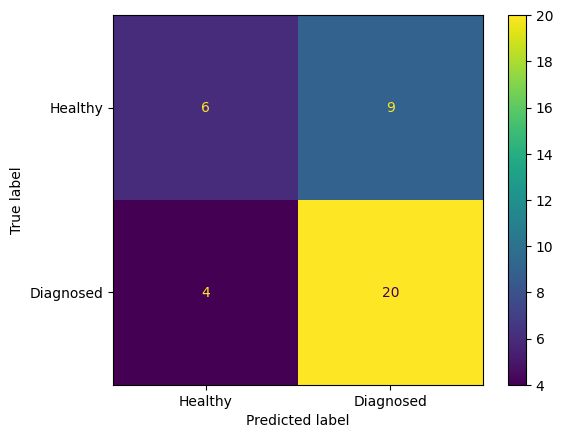

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = parkinsons_KNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
label_map = {0: "Healthy", 1: "Diagnosed"}
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[c] for c in best_knn.classes_])
plot.plot()
plt.show()

Tuned Confusion Matrix

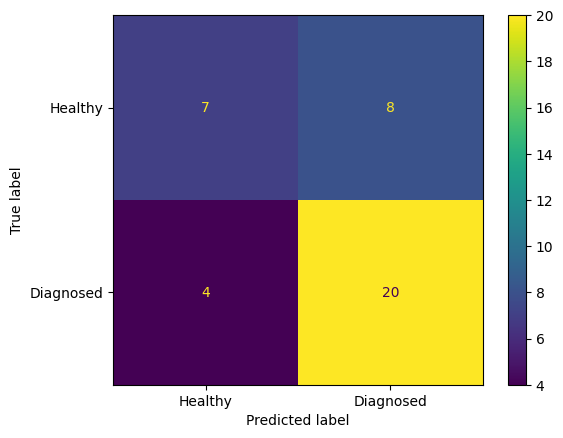

In [ ]:
y_pred = best_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
label_map = {0: "Healthy", 1: "Diagnosed"}
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[c] for c in best_knn.classes_])
plot.plot()
plt.show()

Elbow plot

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
k_values = list(range(1, 12))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_means = []
cv_stds = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="accuracy")
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

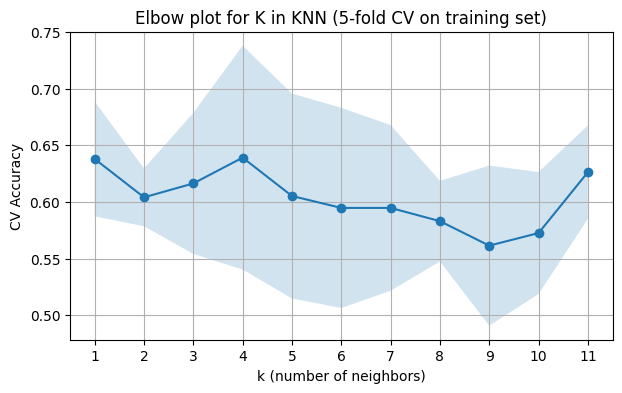

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(k_values, cv_means, marker="o")
plt.fill_between(k_values,
                 np.array(cv_means) - np.array(cv_stds),
                 np.array(cv_means) + np.array(cv_stds),
                 alpha=0.2)
plt.xlabel("k (number of neighbors)")
plt.ylabel("CV Accuracy")
plt.title("Elbow plot for K in KNN (5-fold CV on training set)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# **Vanilla Forest Model**

# **Tuned Forest Model**

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_absolute_error, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [ ]:
from sklearn.model_selection import train_test_split
y = df_clean['Diagnosed_String']
X = df_clean.drop(columns=['Diagnosed', 'Diagnosed_String'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify = y, random_state=42)

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_vanilla_accuracy = accuracy_score(y_test, dt_pred)
print(f"Decision Tree Accuracy: {dt_vanilla_accuracy:.6f}")

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_vanilla_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_vanilla_accuracy:.6f}")

Decision Tree Accuracy: 0.538462
Random Forest Accuracy: 0.769231


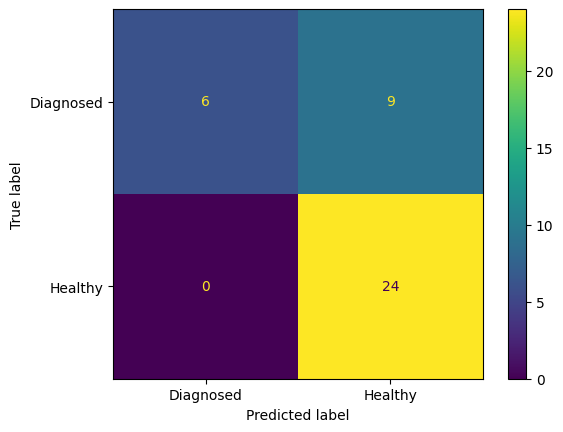

In [ ]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
plot.plot()
plt.show()

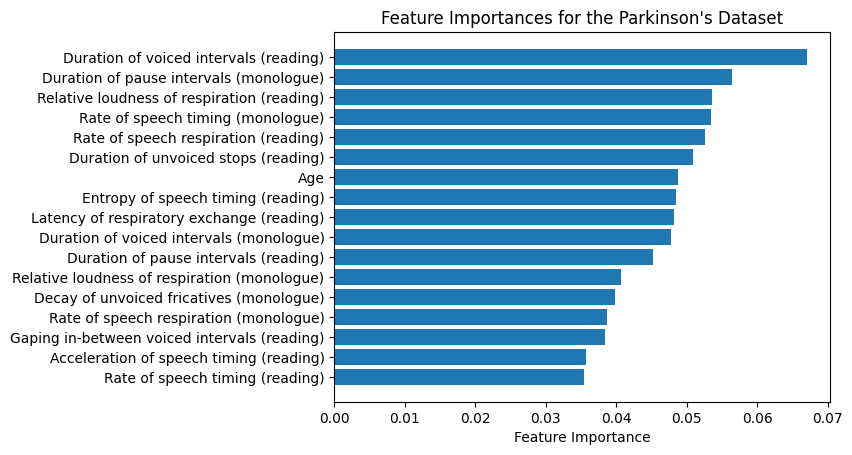

In [ ]:
dictionary = {"Feature": X.columns, "Importance": rf.feature_importances_}
df = pd.DataFrame(dictionary)
df = df.sort_values('Importance', ascending=False).head(17)

plt.figure()
plt.barh(df['Feature'].loc[::-1], df['Importance'].loc[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for the Parkinson\'s Dataset')
plt.show()

In [ ]:
keep_cols = df.iloc[:17,:]['Feature'].to_list()
X_clean_drop_features = X.drop(columns=X.columns.difference(keep_cols))
print(keep_cols)

X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_clean_drop_features, y, test_size=0.3, random_state=42)

rf_drop = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_drop.fit(X_train_drop, y_train_drop)
rf_drop_pred = rf_drop.predict(X_test_drop)
rf_drop_accuracy = accuracy_score(y_test_drop, rf_drop_pred)
print(f"Random Forest Accuracy: {rf_drop_accuracy:.6f}")

['Duration of voiced intervals (reading)', 'Duration of pause intervals (monologue)', 'Relative loudness of respiration (reading)', 'Rate of speech timing (monologue)', 'Rate of speech respiration (reading)', 'Duration of unvoiced stops (reading)', 'Age', 'Entropy of speech timing (reading)', 'Latency of respiratory exchange (reading)', 'Duration of voiced intervals (monologue)', 'Duration of pause intervals (reading)', 'Relative loudness of respiration (monologue)', 'Decay of unvoiced fricatives (monologue)', 'Rate of speech respiration (monologue)', 'Gaping in-between voiced intervals (reading)', 'Acceleration of speech timing (reading)', 'Rate of speech timing (reading)']
Random Forest Accuracy: 0.794872


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_drop, y_train_drop)
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test_drop)
best_rf_accuracy = accuracy_score(y_test_drop, best_rf_pred)
print(best_rf.get_params())
print(f"Best Random Forest Accuracy: {best_rf_accuracy}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Best Random Forest Accuracy: 0.8205128205128205


In [ ]:
cm = confusion_matrix(y_test, best_rf_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
plot.plot()
plt.show()

# **PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_train)
proportion_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(proportion_variance)

plt.figure(figsize=(15, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained as More Components are Included')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# the plot shows that 6 components explain over 95% of the variance

In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Parkinson\'s Dataset')
plt.colorbar(scatter)
plt.show()
# purple represents 0=healthy, yellow represents 1=diagnosed

In [ ]:
loadings_2d = pca.components_.T[:, 0:2]

# 3. Create the Loadings Table using the original feature names as the index
feature_names = X_train.columns.tolist()

loadings_df = pd.DataFrame(loadings_2d,
                           columns=['PC1 Loading', 'PC2 Loading'],
                           index=feature_names)

# 4. Print the explained variance ratio for the TOP TWO components
print(f"Variance Explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance Explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%\n")

# 5. Highlight the Top 5 contributors for better interpretation

# Get the features with the largest ABSOLUTE loading value for PC1
pc1_top_features = loadings_df['PC1 Loading'].abs().sort_values(ascending=False).head(5)

print("--- TOP 5 FEATURES CONTRIBUTING TO PC1 ---")
print(loadings_df.loc[pc1_top_features.index])
print("\n" + "="*40 + "\n")

# Get the features with the largest ABSOLUTE loading value for PC2
pc2_top_features = loadings_df['PC2 Loading'].abs().sort_values(ascending=False).head(5)

print("--- TOP 5 FEATURES CONTRIBUTING TO PC2 ---")
print(loadings_df.loc[pc2_top_features.index])